# **Resumen:** 
Vamos a hacer uso de de una dataset con personas que tienen insuficiencia cardiaca. Vamos a agrupar y usar patrones frecuentes para determinar que tipos de personas son máás propensas a sufrir de insuficiencia cardiaca.

# Descripción de los datos

- age: Edad del paciente (años)
- anaemia: disminución de los glóbulos rojos o de la hemoglobin (boleano) 0=false(no tiene);1=true(si tiene)
- high blood pressure: Si el paciente tiene hipertensión (boleano) 0=false(no tiene);1=true(si tiene)
- creatinine phosphokinase (CPK): nivel de la enzima CPK en la sangre (mcg/L)
- diabetes: Sí el paciente tiene diabetes (boleano) 0=false(no tiene); 1=true(si tiene)
- ejection fraction: porcentaje de sangre que sale del corazón en cada contracción (porcentaje)
- platelets: plaquetas en la sangre (kiloplaquetas/mL)
- sex: Mujer o Hombre (binario) mujer=0; hombre=1
- serum creatinine: nivel de creatinina sérica en la sangre (mg/dL)
- serum sodium: nivel de sodio sérico en la sangre (mEq/L)
- smoking: Si el paciente fuma o no (boleano) 0=false(no fuma); 1=true(si fuma)
- time: período de seguimiento (días)
- [target] death event: si el paciente falleció durante el período de seguimiento (boleano) 0 = sobrevivio; 1 = muerto

Para más información de los datos consultar: [dataset](https://archive.ics.uci.edu/ml/datasets/Heart+failure+clinical+records#)

Paper de [Davide Chicco & Giuseppe Jurman](https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/s12911-020-1023-5) con una explicación más amplía

In [1]:
#!pip install -U yellowbrick

# **INDICE**
> [Procesamiento de datos](#procesamiento)

> > [Elección de columnas para trabajo](#columnsw)

> [Clusterisación: K-Means](#kmeans)

>[Análisis de grupos](#analisis)

In [2]:
#Cargamos las librerias que vamos a necesitar
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns
from yellowbrick.cluster import silhouette_visualizer
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

In [3]:
# Cargamos los datos con los que vamos a trabajar
heart_failure = pd.read_csv('/content/heart_failure_clinical_records_dataset.csv')

In [4]:
heart_failure.shape

(299, 13)

In [5]:
heart_failure.head(5)

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


# Procesamiento

<a id="procesamiento"><h1><strong>Procesamiento de datos</strong></h1></a>

* **Corroborar que no hay datos nulos**

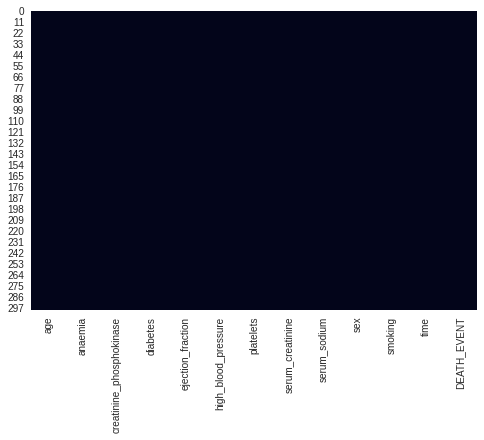

In [6]:
# ESTADO DE LOS DATOS
sns.heatmap(heart_failure.isnull(), cbar=False)

> A partir del mapa de calor podemos observar que no hay datos faltantes en nuestro conjunto de datos

## Elección de columnas

 <a id ="columnsw"><h1><strong>Elección de columnas para trabajo</strong></h1></a>

In [7]:
heart_failure.columns

Index(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time',
       'DEATH_EVENT'],
      dtype='object')

El corazón es un organo que su principal función es la de irrigar a todos los organos, cuando este no tiene la suficiente fuerza para bombear la sangre a eso se le llama insuficiencia cardiaca. Por lo tanto ¿qué tanta importancia tiene la diabetes aquí? Estamos estudiando fallas de corazón. Por lo tanto hemos de proceder a realizar una matriz de correlación

In [8]:

##No creo que ocupemos la columna time
#Aunque en la matriz de correlacion vemos que time y death_event estan inversamente correlacionadas
#otra cosa, si estamos estudiando fallas de corazon, Que tanta importancia tiene la diabetes?
#En la matriz de correlacion, la diabetes esta muy poco correlacionada con Death event

#heart_failure.drop(['time'],axis=1,inplace=True)

In [9]:
#heart_failure['time']=heart_failure['time']*-1

In [10]:
#heart_failure['ejection_fraction']=heart_failure['ejection_fraction']*-1

In [11]:
heart_failure.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


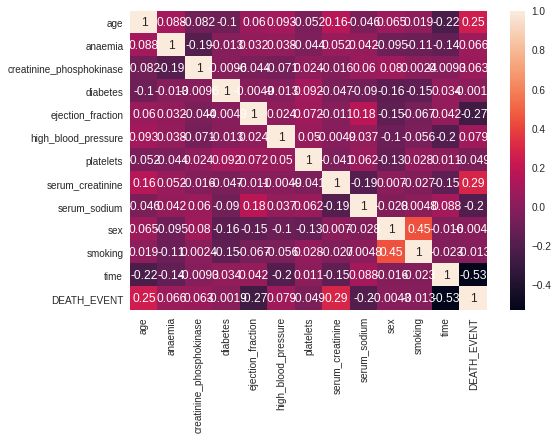

<Figure size 1440x1152 with 0 Axes>

In [12]:
correlation_mat = heart_failure.corr().unstack()
R=heart_failure.corr()
#print(correlation_mat)
sns.heatmap(R, annot = True)
plt.figure(figsize=(20,16))
plt.show()

A partir de la matriz de correlación podemos filtrar los datos de trabajo. Tomamos los datos con una correlación mayor o igual a 0.25 con el evento de muerte. Por lo tanto los datos de trabajo son: 

- Age
- Ejection Fraction
- Serum Creatinine
- Time

In [13]:
heart_failure.columns

Index(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time',
       'DEATH_EVENT'],
      dtype='object')

In [14]:
eval = heart_failure[['age','ejection_fraction','serum_creatinine','time', 'DEATH_EVENT']]
eval.head()

,age,ejection_fraction,serum_creatinine,time,DEATH_EVENT
0,75.0,20,1.9,4,1
1,55.0,38,1.1,6,1
2,65.0,20,1.3,7,1
3,50.0,20,1.9,7,1
4,65.0,20,2.7,8,1


# Clusterisación


<a id="kmeans"><h1><strong>Clusterisación: K-Means</strong></h1></a>

## **K-means y la elección efectiva de K**

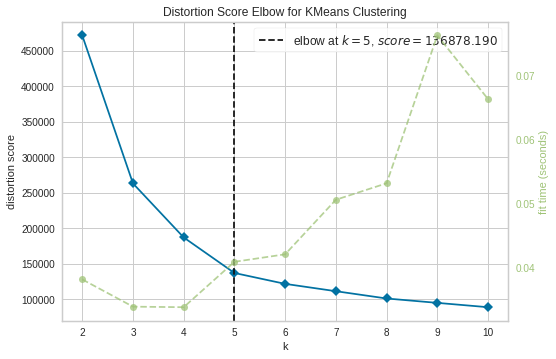

In [15]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=10)
visualizer.fit(eval)
visualizer.show()

Para K= 3


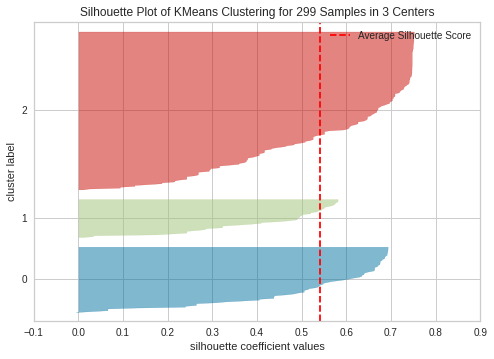

Para K= 4


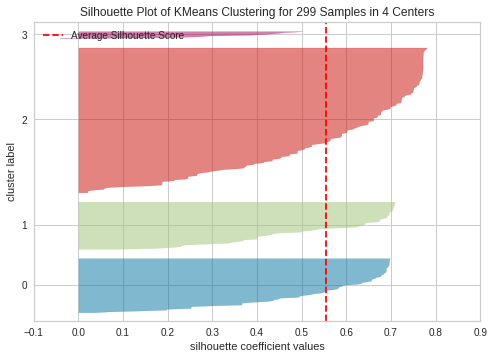

Para K= 5


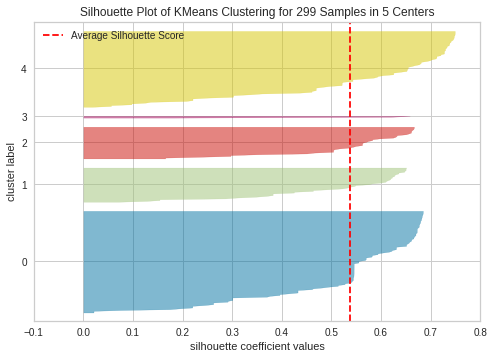

In [16]:
for i in range(3,6):
  print("Para K=",i)
  silhouette_visualizer(KMeans(i), heart_failure, colors='yellowbrick')

A partir de las visualizaciones anteriores, tomamos **k=5**
cuya justificación en la primer gráfica consiste en que 5 es donde sucede el cruce entre el número de k y la distorcióón del puntaje, si bajamos o aumentamos k, podemos obtener fallas en el puntaje. Asi mismo podemos ver que en el indice de silhouette, 5 forma 5 grupos que el algoritmo distingue perfectamente, por lo tanto. Tomamos **K=5**

## Formación de Clusters

In [29]:
result = KMeans(n_clusters=5,init='random',max_iter=200).fit(eval)
result

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=200, n_clusters=5,
       n_init=10, n_jobs=None, precompute_distances='auto', random_state=None,
       tol=0.0001, verbose=0)

In [30]:
result.labels_

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], dtyp

In [31]:
cluster_result = list(result.labels_)
eval = eval.assign(Cluster_group = cluster_result)
eval.head()

,age,ejection_fraction,serum_creatinine,time,DEATH_EVENT,Cluster_group
0,75.0,20,1.9,4,1,2
1,55.0,38,1.1,6,1,2
2,65.0,20,1.3,7,1,2
3,50.0,20,1.9,7,1,2
4,65.0,20,2.7,8,1,2


## Análisis

<a id="analisis"><h1><stron> Análisis de grupos </strong></h1></a>


In [32]:
cluster_1 = eval[eval['Cluster_group'] == 0]
cluster_1.mean()

age                   59.075290
ejection_fraction     38.903226
serum_creatinine       1.174194
time                 151.387097
DEATH_EVENT            0.354839
Cluster_group          0.000000
dtype: float64

**Cluster 1:** Probabilidad de muerte = 35%
En su mayoría este grupo esta compuesto por personas 
de 59 años. 
Enfoquemonos en los siguientes datos: 
  * age                   59.075290
  * ejection_fraction     38.903226
  * serum_creatinine       1.174194
  * time                 151.387097
  * DEATH_EVENT            0.354839

Para hacer la comparativa con los demás grupos. 

In [37]:
cluster_2 = eval[eval['Cluster_group'] == 1]
cluster_2.mean()

age                   60.062500
ejection_fraction     37.531250
serum_creatinine       1.366719
time                 200.890625
DEATH_EVENT            0.109375
Cluster_group          1.000000
dtype: float64

Cluster 2: Probabilidad de muerte = 10% 
En su mayoría este grupo esta compuesto por personas de 60 años.
Enfoquemonos en los siguientes datos:
  * age                   60.062500
  * ejection_fraction     37.531250
  * serum_creatinine       1.366719
  * time                 200.890625
  * DEATH_EVENT            0.109375
  
Para hacer la comparativa con los demás grupos.


In [34]:
cluster_3 = eval[eval['Cluster_group'] == 2]
cluster_3.mean()

age                  66.433333
ejection_fraction    35.733333
serum_creatinine      1.831500
time                 26.166667
DEATH_EVENT           0.866667
Cluster_group         2.000000
dtype: float64

Cluster 3: Probabilidad de muerte = 86% 
En su mayoría este grupo esta compuesto por personas de 66 años.
Enfoquemonos en los siguientes datos:
  * age                  66.433333
  * ejection_fraction    35.733333
  * serum_creatinine      1.831500
  * time                 26.166667
  * DEATH_EVENT           0.866667
  
Para hacer la comparativa con los demás grupos.

In [35]:
cluster_4 = eval[eval['Cluster_group'] == 3]
cluster_4.mean()

age                   56.095238
ejection_fraction     38.380952
serum_creatinine       1.191190
time                 249.190476
DEATH_EVENT            0.047619
Cluster_group          3.000000
dtype: float64

Cluster 4: Probabilidad de muerte = 4% 
En su mayoría este grupo esta compuesto por personas de 56 años.
Enfoquemonos en los siguientes datos:
  * age                   56.095238
  * ejection_fraction     38.380952
  * serum_creatinine       1.191190
  * time                 249.190476
  * DEATH_EVENT            0.047619
  
Para hacer la comparativa con los demás grupos.

In [36]:
cluster_5 = eval[eval['Cluster_group'] == 4]
cluster_5.mean()

age                  60.509804
ejection_fraction    39.441176
serum_creatinine      1.303725
time                 91.784314
DEATH_EVENT           0.235294
Cluster_group         4.000000
dtype: float64

Cluster 5: Probabilidad de muerte = 23% 
En su mayoría este grupo esta compuesto por personas de 60 años.
Enfoquemonos en los siguientes datos:
  * age                  60.509804
  * ejection_fraction    39.441176
  * serum_creatinine      1.303725
  * time                 91.784314
  * DEATH_EVENT           0.235294
  
Para hacer la comparativa con los demás grupos.

Tenemos entonces 5 grupos, formados por las características previamente descritas. 
  
  
> Nota: **Es probable que si vuelven a correr todo el notebook, las
descripciones de cada cluster no correspondan. Pero no hay problema, simplemente cambiaron de cluster, es decir se formaron los mismos 5 clusters con las mismas caracteristicas, tal vez una ligera variación en algunos valores, pero son los mismo**

#Experimento Kalid xd 
apartado para probar cositas

In [ ]:
#heart_failure['serum_sodium']=heart_failure['serum_sodium']*-1

In [ ]:
#eval2 = heart_failure[['ejection_fraction','serum_creatinine']]
eval2 = heart_failure[['age','ejection_fraction','serum_creatinine','time']]
eval2.head()

,age,ejection_fraction,serum_creatinine,time
0,75.0,-20,1.9,-4
1,55.0,-38,1.1,-6
2,65.0,-20,1.3,-7
3,50.0,-20,1.9,-7
4,65.0,-20,2.7,-8


age                age                  1.000000
                   ejection_fraction   -0.060098
                   serum_creatinine     0.159187
                   time                 0.224068
                   DEATH_EVENT          0.253729
ejection_fraction  age                 -0.060098
                   ejection_fraction    1.000000
                   serum_creatinine     0.011302
                   time                 0.041729
                   DEATH_EVENT          0.268603
serum_creatinine   age                  0.159187
                   ejection_fraction    0.011302
                   serum_creatinine     1.000000
                   time                 0.149315
                   DEATH_EVENT          0.294278
time               age                  0.224068
                   ejection_fraction    0.041729
                   serum_creatinine     0.149315
                   time                 1.000000
                   DEATH_EVENT          0.526964
DEATH_EVENT        a

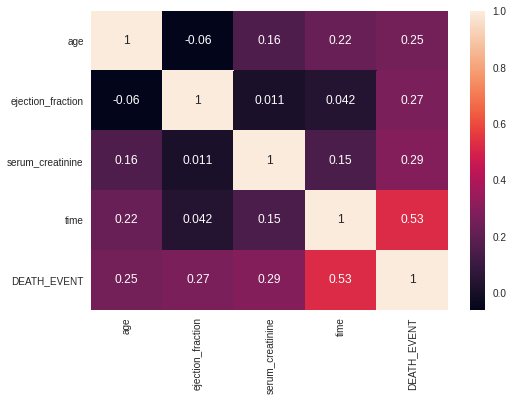

In [ ]:
correlation_mat = heart_failure[['age','ejection_fraction','serum_creatinine','time','DEATH_EVENT']].corr().unstack()

R=heart_failure[['age','ejection_fraction','serum_creatinine','time','DEATH_EVENT']].corr()

print(correlation_mat)
sns.heatmap(R, annot = True)


plt.show()

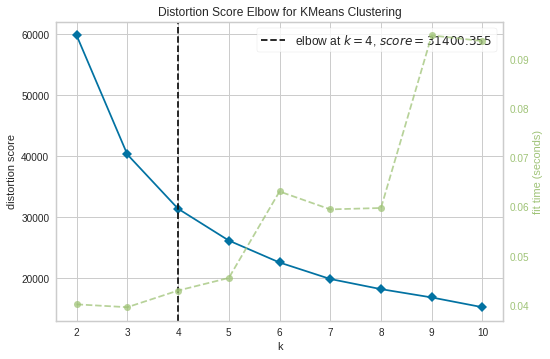

In [ ]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=10)
visualizer.fit(eval2)
visualizer.show()

In [ ]:
result2 = KMeans(n_clusters=5,init='random',max_iter=200).fit(eval2)
result2

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=200, n_clusters=5,
       n_init=10, n_jobs=None, precompute_distances='auto', random_state=None,
       tol=0.0001, verbose=0)

In [ ]:
cluster_result2 = list(result2.labels_)
heart_failure2 = heart_failure.assign(Cluster_group = cluster_result2)
heart_failure2.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT,Cluster_group
0,75.0,0,582,0,-20,1,265000.00,1.9,-130,1,0,-4,1,3
1,55.0,0,7861,0,-38,0,263358.03,1.1,-136,1,0,-6,1,4
2,65.0,0,146,0,-20,0,162000.00,1.3,-129,1,1,-7,1,3
3,50.0,1,111,0,-20,0,210000.00,1.9,-137,1,0,-7,1,1
4,65.0,1,160,1,-20,0,327000.00,2.7,-116,0,0,-8,1,3


In [ ]:
cluster_2_1 = heart_failure2[heart_failure2['Cluster_group'] == 0]
cluster_2_1.mean()

age                             78.918367
anaemia                          0.387755
creatinine_phosphokinase       622.265306
diabetes                         0.326531
ejection_fraction              -42.775510
high_blood_pressure              0.428571
platelets                   259916.125510
serum_creatinine                 1.628571
serum_sodium                  -136.102041
sex                              0.755102
smoking                          0.326531
time                          -108.530612
DEATH_EVENT                      0.489796
Cluster_group                    0.000000
dtype: float64

In [ ]:
cluster_2_1 = heart_failure2[heart_failure2['Cluster_group'] == 1]
cluster_2_1.mean()

age                             46.619048
anaemia                          0.380952
creatinine_phosphokinase       783.952381
diabetes                         0.444444
ejection_fraction              -31.095238
high_blood_pressure              0.349206
platelets                   275583.970635
serum_creatinine                 1.114921
serum_sodium                  -136.714286
sex                              0.650794
smoking                          0.317460
time                          -134.079365
DEATH_EVENT                      0.301587
Cluster_group                    1.000000
dtype: float64

In [ ]:
cluster_2_1 = heart_failure2[heart_failure2['Cluster_group'] == 2]
cluster_2_1.mean()

age                             58.021739
anaemia                          0.478261
creatinine_phosphokinase       441.478261
diabetes                         0.413043
ejection_fraction              -58.347826
high_blood_pressure              0.369565
platelets                   267111.916957
serum_creatinine                 1.353043
serum_sodium                  -138.000000
sex                              0.500000
smoking                          0.282609
time                          -120.869565
DEATH_EVENT                      0.195652
Cluster_group                    2.000000
dtype: float64

In [ ]:
cluster_2_1 = heart_failure2[heart_failure2['Cluster_group'] == 3]
cluster_2_1.mean()

age                             65.979803
anaemia                          0.484848
creatinine_phosphokinase       386.545455
diabetes                         0.393939
ejection_fraction              -26.242424
high_blood_pressure              0.363636
platelets                   255748.971515
serum_creatinine                 1.602424
serum_sodium                  -135.803030
sex                              0.696970
smoking                          0.378788
time                          -117.075758
DEATH_EVENT                      0.545455
Cluster_group                    3.000000
dtype: float64

In [ ]:
cluster_2_1 = heart_failure2[heart_failure2['Cluster_group'] == 4]
cluster_2_1.mean()

age                             58.155560
anaemia                          0.426667
creatinine_phosphokinase       643.600000
diabetes                         0.480000
ejection_fraction              -38.880000
high_blood_pressure              0.280000
platelets                   259730.535333
serum_creatinine                 1.316400
serum_sodium                  -136.773333
sex                              0.626667
smoking                          0.293333
time                          -158.613333
DEATH_EVENT                      0.106667
Cluster_group                    4.000000
dtype: float64